In [ ]:
!pip install pytorch
!pip install segmentation_models_pytorch

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
import os
import numpy as np
from random import randint
from tqdm import tqdm

CHANNELS = 7

#Preprocessing and Building PyTorch Dataset

In [ ]:
class FireDataset(Dataset):

    def __init__(self,
                 input_folder, label_folder,
                 input_transforms=transforms.ToTensor(),
                 label_transforms=transforms.ToTensor(),
                 label=0):

        pre_files = os.listdir(input_folder)
        post_files = os.listdir(label_folder)

        self.input_files = [input_folder + '/' + path for path in pre_files]
        self.label_files = [label_folder + '/' + path for path in post_files]

        self.label_idx = label
        self.input_transform = input_transforms
        self.label_transform = label_transforms

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):

        path_to_input = self.input_files[idx]
        path_to_label = self.label_files[idx]

        input = np.load(path_to_input).reshape(64, 64, CHANNELS)
        label = np.load(path_to_label)[self.label_idx].reshape(64, 64, 1)
        input, label = self.input_transform(input), self.label_transform(label)

        h_flip, v_flip = transforms.RandomHorizontalFlip(p=1), transforms.RandomVerticalFlip(p=1)

        if randint(0, 9) > 4:
            input, label = h_flip(input), h_flip(label)

        if randint(0, 9) > 4:
            input, label = v_flip(input), v_flip(label)

        return input, label

In [ ]:

input_folder = '/content/drive/MyDrive/USGSData/processed_images/input2'
label_folder = '/content/drive/MyDrive/USGSData/processed_images/target2'
"""
input_files = [input_folder + '/' + path for path in os.listdir(input_folder)]
label_files = [label_folder + '/' + path for path in os.listdir(label_folder)]

ctr, s = 0, [0 for _ in range(CHANNELS)]

for f in input_files + label_files:
    data = np.load(f)
    for channel in range(CHANNELS):
        for r in data[channel].flatten():
            s[channel] += r
            ctr += 1

means = np.array(s) / ctr

s_square = [0 for _ in range(CHANNELS)]
for f in input_files + label_files:
    data = np.load(f)
    for channel in range(CHANNELS):
        for r in data[channel].flatten():
            s_square[channel] += (r - means[channel]) ** 2

stdev = (np.array(s_square)/ctr) ** 0.5

ctr, means, stdev
"""

"\ninput_files = [input_folder + '/' + path for path in os.listdir(input_folder)]\nlabel_files = [label_folder + '/' + path for path in os.listdir(label_folder)]\n\nctr, s = 0, [0 for _ in range(CHANNELS)]\n\nfor f in input_files + label_files:\n    data = np.load(f)\n    for channel in range(CHANNELS):\n        for r in data[channel].flatten():\n            s[channel] += r\n            ctr += 1\n\nmeans = np.array(s) / ctr\n\ns_square = [0 for _ in range(CHANNELS)]\nfor f in input_files + label_files:\n    data = np.load(f)\n    for channel in range(CHANNELS):\n        for r in data[channel].flatten():\n            s_square[channel] += (r - means[channel]) ** 2\n\nstdev = (np.array(s_square)/ctr) ** 0.5\n\nctr, means, stdev\n"

In [ ]:
label_idx = 6

means=(0.0032137, 0.01951275, 0.01347293, 0.03039954, 0.00624942, -0.01392061, 0.0490588)
stdev=(0.04064116, 0.05769031, 0.03293696, 0.07551957, 0.03757489, 0.03575791, 0.11903611)

input_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stdev)
])

label_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((means[label_idx]), (stdev[label_idx]))
])

fire_data = FireDataset(input_folder, label_folder,
                        input_transforms=input_transforms,
                        label_transforms=label_transforms,
                        label=label_idx)

for image, label in fire_data:
    print(image.shape)
    print(label.shape)
    break

torch.Size([7, 64, 64])
torch.Size([1, 64, 64])


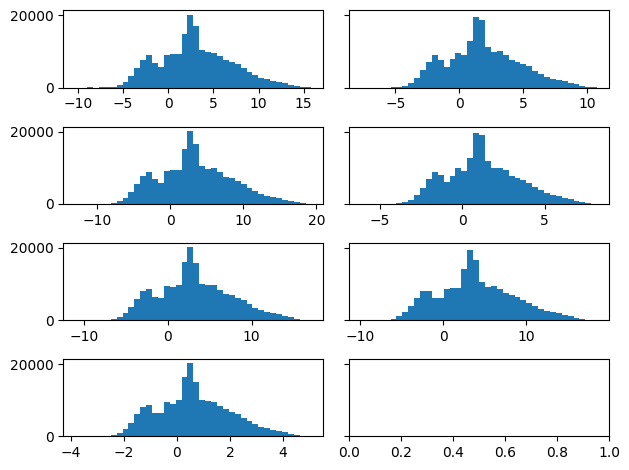

In [ ]:
import matplotlib.pyplot as plt

ctr = 0
all_pixels = [[] for _ in range(CHANNELS)]
for image, label in fire_data:
    for i in range(CHANNELS):
        all_pixels[i] += image[i].flatten()
    ctr += 1
    if ctr >= 50:
        break

fig, axs = plt.subplots(4, 2, sharey=True, tight_layout=True)
for i in range(CHANNELS):
    axs[i // 2][i % 2].hist(all_pixels[i], bins=40)


In [ ]:
fire_data_loader = DataLoader(fire_data,
                              batch_size=16,
                              shuffle=True)

for image, label in fire_data_loader:
    print(image.shape)
    print(label.shape)
    break

torch.Size([16, 7, 64, 64])
torch.Size([16, 1, 64, 64])


In [ ]:
len(fire_data_loader)

52

In [ ]:
!nvidia-smi

Fri Sep  8 06:32:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    29W /  70W |   5313MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Regression Using PyTorch

In [ ]:
x = torch.ones(1, requires_grad=True)
y = x + 2
z = y**2 * 3
z.backward()
x.grad

tensor([18.])

In [ ]:
x = np.arange(0, 10, 0.5)
x = x.reshape(-1, 1)

y = 2 + 3*x
y = y.reshape(-1, 1)

torch.seed()

class Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 1)
    def forward(self, x):
        y = self.fc1(x)
        return y

model = Regression()
for name, params in model.named_parameters():
    print(name, params)

fc1.weight Parameter containing:
tensor([[0.0038]], requires_grad=True)
fc1.bias Parameter containing:
tensor([-0.3118], requires_grad=True)


In [ ]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 5000
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
x.shape, y.shape

(torch.Size([20, 1]), torch.Size([20, 1]))

In [ ]:
for epoch in range(epochs):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:

for name, params in model.named_parameters():
    print(name, params)

fc1.weight Parameter containing:
tensor([[3.0000]], requires_grad=True)
fc1.bias Parameter containing:
tensor([2.0000], requires_grad=True)


#Loading SMP Model

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet("efficientnet-b7", encoder_weights="imagenet", in_channels=CHANNELS)
model = model.to(DEVICE)

head_training = True

if not head_training:
    for name, param in model.named_parameters():
        if "encoder" in name:
            param.requires_grad_(False)
        print(name)

In [ ]:
loss_fn = nn.MSELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr=0.00025, weight_decay=0.01)
epochs = 20
batch_size = 32

In [ ]:
train_samples, test_samples = int(0.9 * len(fire_data)), len(fire_data) - int(0.9 * len(fire_data))
train_dataset, val_dataset = torch.utils.data.random_split(fire_data, lengths=[train_samples, test_samples])

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def train(model, device, epochs, optimizer, loss_fn, batch_size, trainloader, valloader):

    log_training = {"epoch": [],
                    "training_loss": [],
                    "training_acc": [],
                    "validation_loss": [],
                    "validation_acc": []}

    for epoch in range(1, epochs + 1):

        print(f"Starting Epoch {epoch}")
        training_losses, training_accuracies = [], []
        validation_losses, validation_accuracies = [], []

        model.train()

        for image, label in tqdm(trainloader):

            image, label = image.float(), label.float()
            image, label = image.to(DEVICE), label.to(DEVICE)

            optimizer.zero_grad()
            out = model.forward(image)

            loss = loss_fn(out, label)
            training_losses.append(loss.item())

            loss.backward()
            optimizer.step()

        model.eval()

        for image, label in tqdm(valloader):

            image, label = image.float(), label.float()
            image, label = image.to(DEVICE), label.to(DEVICE)

            with torch.no_grad():

                out = model.forward(image)

                loss = loss_fn(out, label)
                validation_losses.append(loss.item())

        training_loss_mean = np.mean(training_losses)
        valid_loss_mean = np.mean(validation_losses)

        log_training["epoch"].append(epoch)
        log_training["training_loss"].append(training_loss_mean)
        log_training["validation_loss"].append(valid_loss_mean)

        print("Training Loss:", training_loss_mean)
        print("Validation Loss:", valid_loss_mean)

    return log_training, model

In [ ]:
log, model = train(model=model,
                   device=DEVICE,
                   epochs=epochs,
                   optimizer=optimizer,
                   loss_fn=loss_fn,
                   batch_size=batch_size,
                   trainloader=trainloader,
                   valloader=valloader)

Starting Epoch 1


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Training Loss: 6.031615932782491
Validation Loss: 6.684011300404866
Starting Epoch 2


100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


Training Loss: 6.050315419832866
Validation Loss: 6.387601216634114
Starting Epoch 3


100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Training Loss: 6.076245208581288
Validation Loss: 6.296313444773356
Starting Epoch 4


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Training Loss: 6.045862416426341
Validation Loss: 6.179444313049316
Starting Epoch 5


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Training Loss: 6.075172642866771
Validation Loss: 6.153155167897542
Starting Epoch 6


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Training Loss: 6.039697666962941
Validation Loss: 6.157818794250488
Starting Epoch 7


100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


Training Loss: 6.089176714420319
Validation Loss: 6.1406551996866865
Starting Epoch 8


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Training Loss: 6.072279433409373
Validation Loss: 6.098822116851807
Starting Epoch 9


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Training Loss: 6.126145442326863
Validation Loss: 6.131529490152995
Starting Epoch 10


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Training Loss: 6.031417071819305
Validation Loss: 6.07771364847819
Starting Epoch 11


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


Training Loss: 6.0292759736378985
Validation Loss: 6.083453973134358
Starting Epoch 12


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Training Loss: 6.052130202452342
Validation Loss: 6.1117838223775225
Starting Epoch 13


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Training Loss: 6.059448917706807
Validation Loss: 6.110286871592204
Starting Epoch 14


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Training Loss: 5.99137548605601
Validation Loss: 6.129072825113933
Starting Epoch 15


100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Training Loss: 6.140669643878937
Validation Loss: 6.08471663792928
Starting Epoch 16


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Training Loss: 6.0690997044245405
Validation Loss: 6.086564222971599
Starting Epoch 17


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training Loss: 5.988346695899963
Validation Loss: 6.086498419443767
Starting Epoch 18


100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


Training Loss: 6.116633077462514
Validation Loss: 6.136237780253093
Starting Epoch 19


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Training Loss: 6.062257091204326
Validation Loss: 6.11095650990804
Starting Epoch 20


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

Training Loss: 6.061240116755168
Validation Loss: 6.13885513941447


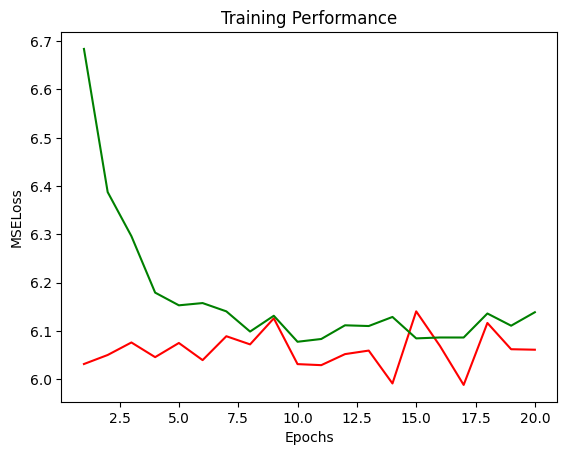

In [ ]:
plt.plot(log["epoch"], log["training_loss"],  "r",  label="With Residuals Training Loss")
plt.plot(log["epoch"], log["validation_loss"], "g", label="With Residuals Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("MSELoss")
plt.title("Training Performance")
plt.show()

In [ ]:
min(log["training_loss"]), min(log["validation_loss"])

(5.988346695899963, 6.07771364847819)

In [ ]:
def show_band(img, title='', size=(8,8), cmap='jet'):
    print(title+' Shape: ', img.shape)
    fig = plt.figure(figsize=size)
    plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap=cmap, vmax=5, vmin=-5)
    plt.axis('off')
    plt.colorbar()
    plt.title(title)
    plt.show()

Error Shape:  (64, 64)


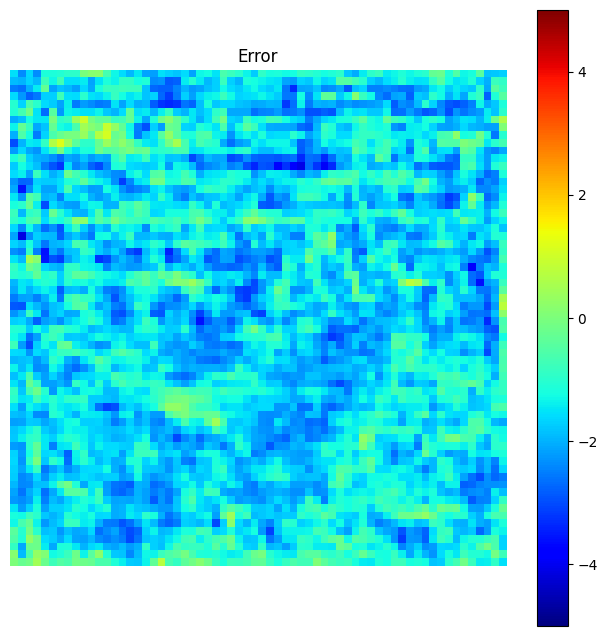

Error Shape:  (64, 64)


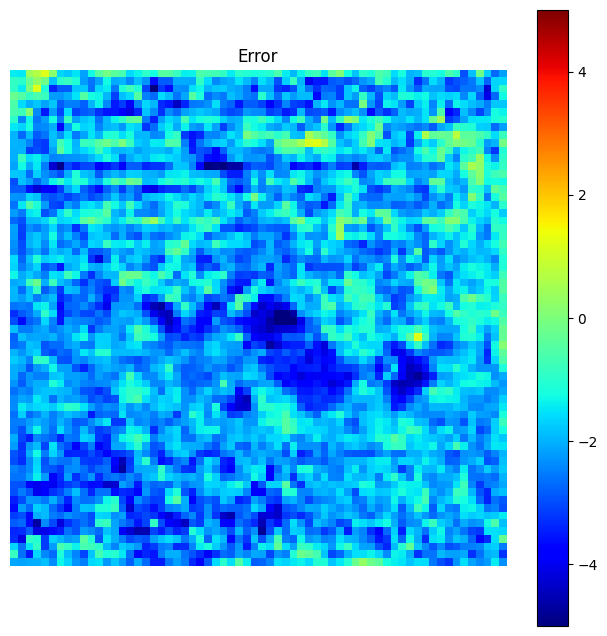

Error Shape:  (64, 64)


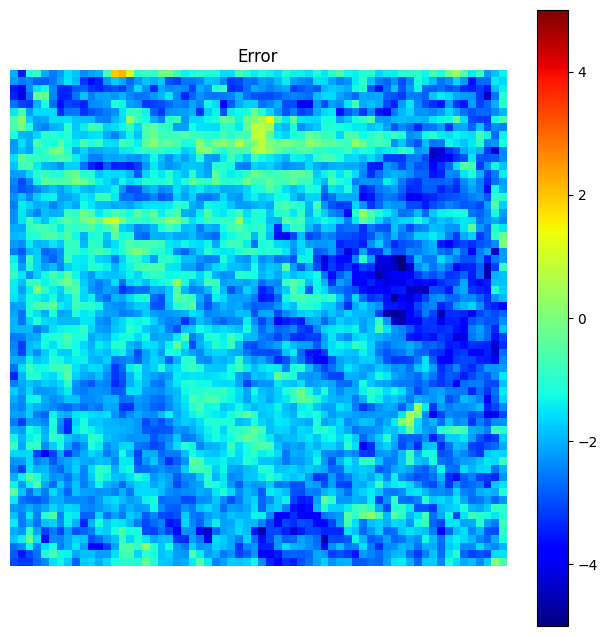

In [ ]:
import numpy

ctr = 0
for X, label in fire_data:
    X, label = X.to(DEVICE), label.to(DEVICE)
    X, label = X.float(), label.float()
    X, label = torch.reshape(X, (1, 7, 64, 64)), torch.reshape(label, (1, 1, 64, 64))
    preds = np.array(model(X).detach().to('cpu').squeeze())
    label = np.array(label.to('cpu').squeeze())
    diff = (preds - label)
    show_band(diff, title="Error")
    ctr += 1
    if ctr > 2:
        break